In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from IPython.display import clear_output
RSEED=123

2022-12-03 18:14:19.291493: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 18:14:19.475144: I tensorflow/core/tpu/tpu_initializer_helper.cc:262] Libtpu path is: libtpu.so
I1203 18:14:19.571400040 1850400 ev_epoll1_linux.cc:121]     grpc epoll fd: 71
D1203 18:14:19.571433919 1850400 ev_posix.cc:141]            Using polling engine: epoll1
D1203 18:14:19.571466102 1850400 lb_policy_registry.cc:43]   registering LB policy factory for "grpclb"
D1203 18:14:19.571474754 1850400 lb_policy_registry.cc:43]   registering LB policy factory for "rls_experimental"
D1203 18:14:19.571483298 1850400 lb_policy_registry.cc:43]   registering LB policy factory for "priority_experimental"
D1203 18:14:19

In [3]:
tf.config.list_logical_devices('TPU')

2022-12-03 18:14:21.626919: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-03 18:14:25.436547: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x799f860 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2022-12-03 18:14:25.436579: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): TPU, 2a886c8
2022-12-03 18:14:25.436587: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): TPU, 2a886c8
2022-12-03 18:14:25.436593: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): TPU, 2a886c8
2022-12-03 18:14:25.436600: I tensorflow/compiler/xla/service/service.cc:181]   

[LogicalDevice(name='/device:TPU:0', device_type='TPU'),
 LogicalDevice(name='/device:TPU:1', device_type='TPU'),
 LogicalDevice(name='/device:TPU:2', device_type='TPU'),
 LogicalDevice(name='/device:TPU:3', device_type='TPU'),
 LogicalDevice(name='/device:TPU:4', device_type='TPU'),
 LogicalDevice(name='/device:TPU:5', device_type='TPU'),
 LogicalDevice(name='/device:TPU:6', device_type='TPU'),
 LogicalDevice(name='/device:TPU:7', device_type='TPU')]

In [4]:
cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.TPUStrategy(cluster_resolver)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU

In [5]:
batch_size = 128
buffer_size = 1000
img_height = 240
img_width = 240
scan_channels = 4
output_classes = 5


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

In [7]:
colour_list = ['w', '#d73027', '#91bfdb', '0.8', '#fee090']
cmap = ListedColormap(colour_list)

def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]),cmap=cmap)
        plt.axis('off')
    plt.show()
  
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
        display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [8]:
images = []
maps = []

train_image_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','image_data')
train_map_dir = os.path.join('data','UPENN-GBM','slice_segmentation_stratify_healthy_dropbg','train','map_data')

# Count pixels for sample weight
pixel_counts = [0,0,0,0,0]
for map_file in os.listdir(train_map_dir):

    seg_map = tf.io.read_file(os.path.join(train_map_dir,map_file))
    seg_map = tf.io.decode_png(seg_map, channels=1)
    
    indices,counts = np.unique(seg_map,return_counts=True)
    for i, index in enumerate(indices):
        pixel_counts[index] += counts[i]
print(pixel_counts)

[3631359787, 6097015, 29626584, 770604523, 9896091]


In [9]:
image_filenames = os.listdir(train_image_dir)
map_filenames = [filename.replace('allseq', 'map') for filename in image_filenames]
image_filepaths = [os.path.join(train_image_dir,filename) for filename in image_filenames]
map_filepaths = [os.path.join(train_map_dir,filename) for filename in map_filenames]

In [10]:
train_image_filepaths, val_image_filepaths, train_map_filepaths, val_map_filepaths = train_test_split(
    image_filepaths, 
    map_filepaths, 
    test_size=0.2,
    random_state=RSEED,
    )
    

In [11]:
train_image_data = tf.data.Dataset.list_files(train_image_filepaths, shuffle=False)
train_map_data = tf.data.Dataset.list_files(train_map_filepaths, shuffle=False)
train_data = tf.data.Dataset.zip((train_image_data, train_map_data))
val_image_data = tf.data.Dataset.list_files(val_image_filepaths, shuffle=False)
val_map_data = tf.data.Dataset.list_files(val_map_filepaths, shuffle=False)
val_data = tf.data.Dataset.zip((val_image_data, val_map_data))

In [12]:
def scaler_0_1(x):
    return x/255.0

def scaler_neg1_1(x):
    return x/127.5 - 1

def alter_segmap(x):
    return tf.where(x==4,tf.constant(3,dtype='uint8'),x)

def read_image_map(image, seg_map):
   image = tf.io.read_file(image)
   image = tf.io.decode_png(image, channels=4)
   seg_map = tf.io.read_file(seg_map)
   seg_map = tf.io.decode_png(seg_map, channels=1)
   # Change scaler below to scaler_0_1 to get initial values between 0 and 1
   return scaler_neg1_1(tf.cast(image, 'float32')) ,seg_map


In [13]:
train_batch = (
    train_data.cache()
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .repeat()
    .map(read_image_map)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_batch = (
    val_data
    .shuffle(buffer_size, seed=tf.constant(RSEED,dtype='int64'))
    .map(read_image_map)
    .batch(batch_size),
)

In [14]:
val_images, val_masks = next(iter(train_batch))

2022-12-03 18:15:50.493004: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


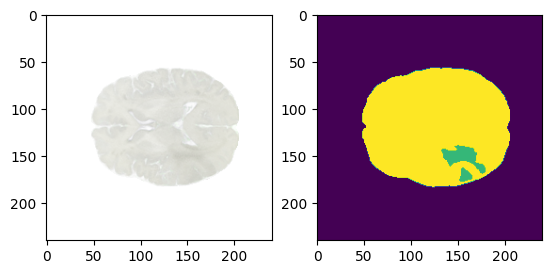

In [15]:
vnum = 7
fig, ax = plt.subplots(1,2)
ax[0].imshow(tf.cast(127.5*(val_images[vnum]+1), 'uint8'))
ax[1].imshow(val_masks[vnum])

In [16]:
# Calculate class weights
weights = 1.0/np.array(pixel_counts)
weights = weights/np.sum(weights)

def add_sample_weights(image, label):
  # The weights for each class, with the constraint that:
  #     sum(class_weights) == 1.0
  #class_weights = tf.constant([2.0, 2.0, 1.0])
  #class_weights = class_weights/tf.reduce_sum(class_weights)

  # Create an image of `sample_weights` by using the label at each pixel as an 
  # index into the `class weights` .
  sample_weights = tf.gather(weights, indices=tf.cast(label, tf.int32))

  return image, label, sample_weights

In [17]:
# Define convolution layer steps
initializer = tf.random_normal_initializer(0., 0.02)

def horizontal_convolution(input, num_filters, dropout_rate=0.0):
    
    x = tf.keras.layers.Conv2D(
        filters=num_filters,
        kernel_size=3,
        padding= 'same',
        strides=1,
        kernel_initializer=initializer,
        use_bias=False,
    )(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
    x = tf.keras.layers.Activation('relu')(x) 
    return x


def down_step(input, num_filters, dropout_rate=0.0):
    x = horizontal_convolution(
        input=input,
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    horizontal_out = horizontal_convolution(
        x, 
        num_filters=num_filters,
        dropout_rate=dropout_rate,
    )
    down_out = tf.keras.layers.MaxPooling2D(
        pool_size=2,
        strides=2, 
        padding = 'same'
    )(horizontal_out)
    return down_out, horizontal_out


def up_step(
    up_input, 
    horizontal_input, 
    num_filters, 
    dropout_rate=0.0, 
):
    x = tf.keras.layers.Conv2DTranspose(
        filters=num_filters,
        kernel_size=3, 
        strides=2,
        padding='same',
        kernel_initializer=initializer,
        use_bias=False,
    )(up_input)
    x = tf.keras.layers.Concatenate()([x, horizontal_input])
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    x = horizontal_convolution(
        x, 
        num_filters=num_filters, 
        dropout_rate=dropout_rate
    )
    return x

In [18]:
# Define U-Net topology
def unet(
    input_shape, 
    output_channels, 
    scale_filters=1.0, 
    dropout_rate=0.0,
    final_dropout=True
    ):

    final_dropout_rate=0.0
    if final_dropout:
        final_dropout_rate = dropout_rate

    inputs = tf.keras.layers.Input(shape=input_shape)

    down_1, cross_1 = down_step(
        inputs, 
        int(64*scale_filters), 
        dropout_rate=dropout_rate
    )  # 240 -> 120
    down_2, cross_2 = down_step(
        down_1, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 120 -> 60
    down_3, cross_3 = down_step(
        down_2, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 30
    down_4, cross_4 = down_step(
        down_3, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 15

    bottom = horizontal_convolution(
        down_4, 
        int(1024*scale_filters), 
        dropout_rate=dropout_rate
    )

    up_4 = up_step(
        bottom, 
        cross_4, 
        int(512*scale_filters), 
        dropout_rate=dropout_rate
    )  # 15 -> 30
    up_3 = up_step(
        up_4, 
        cross_3, 
        int(256*scale_filters), 
        dropout_rate=dropout_rate
    )  # 30 -> 60
    up_2 = up_step(
        up_3, 
        cross_2, 
        int(128*scale_filters), 
        dropout_rate=dropout_rate
    )  # 60 -> 120
    up_1 = up_step(
        up_2, 
        cross_1, 
        int(64*scale_filters), 
        dropout_rate=final_dropout_rate
    )  # 120 -> 240
    
    outputs = horizontal_convolution(up_1, output_channels)

    return tf.keras.Model(inputs=inputs, outputs=outputs)


In [19]:
with strategy.scope():
    input_shape = (img_width,img_height,scan_channels)
    model = unet(
        input_shape=input_shape, 
        output_channels=output_classes, 
        dropout_rate=0.2
    )
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

2022-12-03 18:15:51.217175: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-12-03 18:15:51.281148: I tensorflow/compiler/jit/xla_compilation_cache.cc:476] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 64  2304        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 240, 240, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [21]:
#tf.keras.utils.plot_model(model)

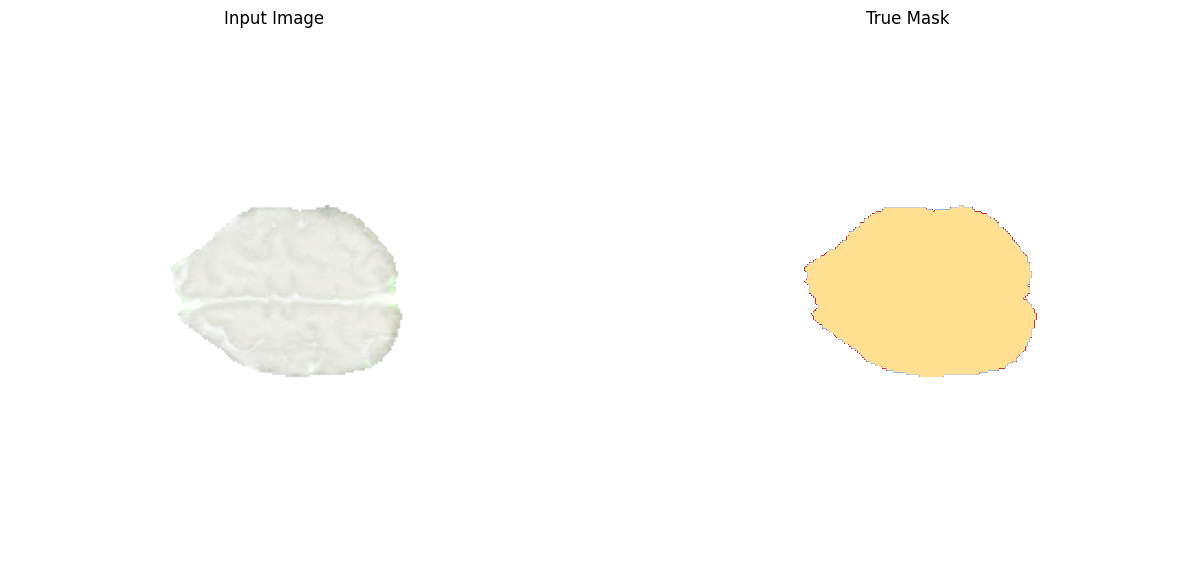

(128, 240, 240, 4) (128, 240, 240, 1)


2022-12-03 18:16:03.372504: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
for images, masks in train_batch.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])
    print(images.shape, masks.shape)

2022-12-03 18:16:04.603634: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:14327324618773702918
2022-12-03 18:16:04.661940: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-03 18:16:04.766346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2022-12-03 18:16:04.911216: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(12846360229965167098), session_name()


1/1 [==============================] - 10s 10s/step


2022-12-03 18:16:13.761530: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 12846360229965167098 with session name  took 8.850189996s and succeeded
2022-12-03 18:16:13.769315: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU host compilation cache: compilation complete for cache_key(12846360229965167098), session_name(), subgraph_key(std::string(property.function_name) = "cluster_predict_function_14327324618773702918", property.function_library_fingerprint = 17167677666572916526, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = false, topology.MissingChipCount() = 0, std::string(property.shapes_prefix) = "2,240,240,4,;", property.guaranteed_constants_size = 0, embedding_partitions_fingerprint = "1688352644216761960")
2022-12-03 18:16:13.769360: I tensorflow/

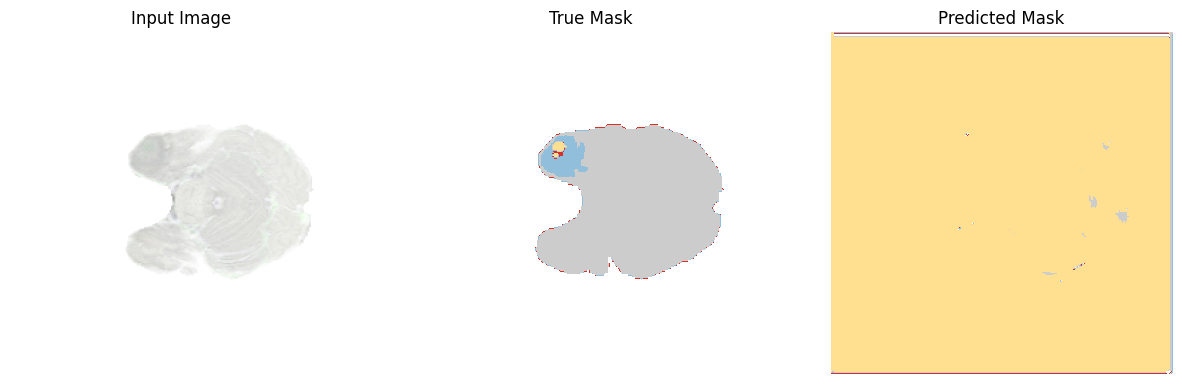

In [23]:
slice_num=17
sample_image, sample_mask = images[slice_num], masks[slice_num]
show_predictions()

In [24]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        #clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [25]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            )

In [26]:
print(len(train_image_filepaths),len(val_image_filepaths))

61772 15443


2022-12-03 18:16:14.576531: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 61772
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}



Epoch 1/40


2022-12-03 18:16:23.710344: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:237] Subgraph fingerprint:13863173949270560333
2022-12-03 18:16:24.092105: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-03 18:16:24.373143: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2022-12-03 18:16:25.827918: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(7387779231950567846), session_name()
2022-12-03 18:17:38.988107: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:210] Compilation of 7387779231950567846 with session name  took 1m13.154873915s and succeeded
2022-12-03 18:17:39.030788: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:470] TPU hos

482/482 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.8197

2022-12-03 18:21:37.386610: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_1"
op: "TensorSliceDataset"
input: "Placeholder/_0"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 15443
  }
}
attr {
  key: "is_files"
  value {
    b: true
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:3"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
    }
  }
}

2022-12-03 

1/1 [==============================] - 0s 471ms/step


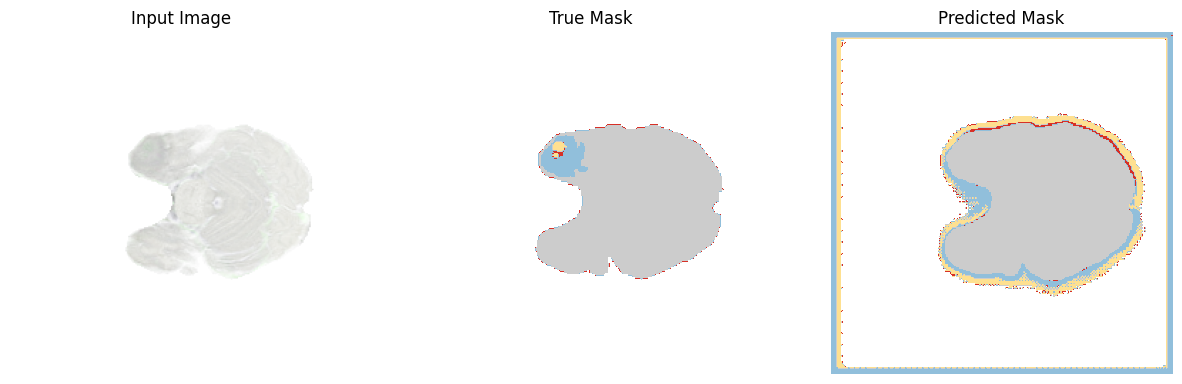


Sample Prediction after epoch 1

482/482 [==============================] - 407s 670ms/step - loss: 0.0028 - accuracy: 0.8197 - val_loss: 1.2914 - val_accuracy: 0.8208
Epoch 2/40
1/1 [==============================] - 0s 436ms/step loss: 0.0020 - accuracy: 0.88


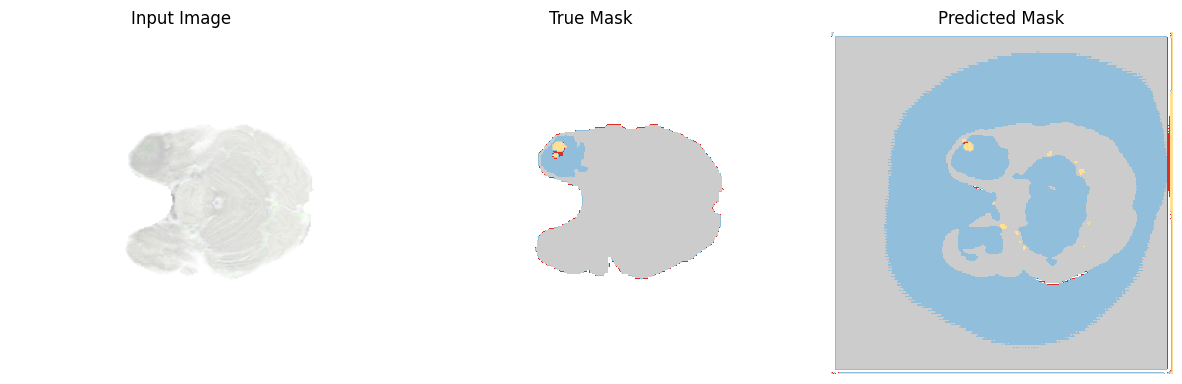


Sample Prediction after epoch 2

482/482 [==============================] - 263s 545ms/step - loss: 0.0020 - accuracy: 0.8897 - val_loss: 1.5264 - val_accuracy: 0.1983
Epoch 3/40
391/482 [=======================>......] - ETA: 44s - loss: 0.0017 - accuracy: 0.9108

In [27]:
#lr 0.0001
TRAIN_LENGTH=61772
EPOCHS = 40
VAL_SUBSPLITS = 1
VALIDATION_STEPS = 15443//batch_size//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size

model_history = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [ ]:
val_images, val_maps = next(iter(val_batch[0].take(1)))

In [ ]:
type(val_maps)

In [ ]:
#val_maps.shape
num = 13
plt.imshow(tf.cast(val_maps[num,:,:,0],'uint8'), cmap=cmap)

In [ ]:
single_img = tf.expand_dims(val_images[num],0)
single_map = tf.expand_dims(val_maps[num],0)


In [ ]:
single_ds = tf.data.Dataset.from_tensor_slices(([single_img],[single_map]))


In [ ]:
show_predictions(single_ds)

In [ ]:
earlystopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            )

In [ ]:
# Train layers below layer 100 in down branch
model.layers[4].trainable = True
for layer in model.layers[4].layers[:100]:
    layer.trainable = False


In [ ]:
with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
model_history_partialrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=50,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)

In [ ]:
show_predictions(single_ds)

In [ ]:
# Train all layers
model.trainable = True



In [ ]:
with strategy.scope():
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005,),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )

In [ ]:
VALIDATION_STEPS = 15443//batch_size

In [ ]:
model_history_fullrelax = model.fit(
    train_batch.map(add_sample_weights), 
    epochs=80,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=model_history_partialrelax.epoch[-1]+1,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batch,
    callbacks=[DisplayCallback(), earlystopping],
)